# Implementing DCGAN to Generate CIFAR Images

Now, we will see how to implement DCGAN in tensorflow. We will learn how to use DCGAN to generate images from the CIFAR-10 dataset. CIFAR-10 (Canadian Institute For Advanced Research) consists of 60,000 images from 10 different classes which include airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. We will examine how can we use DCGAN to generate such images. 

## Import libraries


First, import the required libraries:

In [1]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

from keras.datasets import cifar10

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

from scipy.misc import toimage

Using TensorFlow backend.


## Explore the Dataset

Load the CIFAR dataset:

In [2]:
(x_train, y_train), _ = cifar10.load_data()

#normalize the data
x_train = x_train.astype('float32')/255.0

Let us see what we have in our dataset. Define a helper function for plotting the image:

In [3]:
def plot_images(X):
    plt.figure(1)
    z = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(toimage(X[z]))
            z = z + 1

    plt.show()

Let us plot a few images:

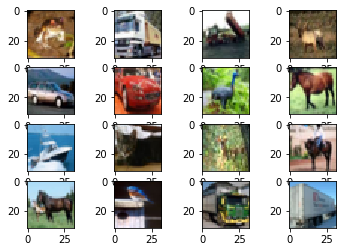

In [4]:
plot_images(x_train[:17])

## Defining Discriminator

We define a discriminator $D$ as a convolutional network with three convolutional layers followed by a fully connected layer. It is composed of a series of convolutional and batch norm layers with Leaky ReLU activations. We apply batch normalization on all layers except at the input layer. 

In [5]:
#initialize weights by drawing from a truncated normal distribution
kernel_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)

In [6]:
def discriminator(input_images, reuse=False, is_training=False, alpha=0.1):
    
    with tf.variable_scope('discriminator', reuse= reuse):
        

        #first convolutional layer with leaky relu activations
        layer1 = tf.layers.conv2d(input_images, 
                                  filters=64, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=kernel_init, 
                                  name='conv1')

        layer1 = tf.nn.leaky_relu(layer1, alpha=0.2, name='leaky_relu1')
    
        #second convolutional layer with batch normalization and leaky relu activations
        layer2 = tf.layers.conv2d(layer1, 
                                  filters=128, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  kernel_initializer=kernel_init, 
                                  name='conv2')
        layer2 = tf.layers.batch_normalization(layer2, training=is_training, name='batch_normalization2')
        
        layer2 = tf.nn.leaky_relu(layer2, alpha=0.2, name='leaky_relu2')

        
        #third convolutional layer with batch normalization followed by leaky relu activations
        layer3 = tf.layers.conv2d(layer2, 
                                 filters=256, 
                                 kernel_size=5, 
                                 strides=1,
                                 padding='same',
                                 name='conv3')
        layer3 = tf.layers.batch_normalization(layer3, training=is_training, name='batch_normalization3')
        layer3 = tf.nn.leaky_relu(layer3, alpha=0.1, name='leaky_relu3')
        
        
        #flatten the output of the final convolutional layer
        layer3 = tf.reshape(layer3, (-1, layer3.shape[1]*layer3.shape[2]*layer3.shape[3]))
        
        
        #define the fully connected layer and return the logits
        logits= tf.layers.dense(layer3, 1)
        
        output = tf.sigmoid(logits)
        
        return logits

## Defining Generator


As we learned generator $G$ in DCGAN performs the transpose convolutional operation.  The generator is composed of convolutional transpose and batch norm layers with ReLU activations.  We apply batch normalization on every layer expect at the last layer. Also, we apply ReLU activations on every layer but for the last layer, we apply tanh activation function to scale the generated image between -1 and +1.

In [7]:
def generator(z, z_dim, batch_size, is_training=False, reuse=False):
    
    with tf.variable_scope('generator', reuse=reuse):
        
        #input
        input_to_conv = tf.layers.dense(z, 8*8*128)
        
        #convert the shape of the input and apply batch normalization followed by a relu activations
        layer1 = tf.reshape(input_to_conv, (-1, 8, 8, 128))
        layer1 = tf.layers.batch_normalization(layer1, training=is_training, name='batch_normalization1')
        layer1 = tf.nn.relu(layer1, name='relu1')
        
        #define the second layer which is the transpose convolution with batch normalization and relu activation
        layer2 = tf.layers.conv2d_transpose(layer1, filters=256, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution2')
        layer2 = tf.layers.batch_normalization(layer2, training=is_training, name='batch_normalization2')
        layer2 = tf.nn.relu(layer2, name='relu2')
        
        #define the third layer with transpose convolution operation with a batch norm and relu activation
        layer3 = tf.layers.conv2d_transpose(layer2, filters=256, kernel_size=5, strides= 2, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution3')
        layer3 = tf.layers.batch_normalization(layer3,training=is_training, name='batch_normalization3')
        layer3 = tf.nn.relu(layer3, name='relu3')
        
        #fourth layer  with convolutional transpose operation with a batch norm and relu activation
        layer4 = tf.layers.conv2d_transpose(layer3, filters=256, kernel_size=5, strides= 1, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution4')
        layer4 = tf.layers.batch_normalization(layer4,training=is_training, name='batch_normalization4')
        layer4 = tf.nn.relu(layer4, name='relu4')
        
        
        #in the final layer, we don't apply batch normalization and instead of relu we use tanh activation
        layer5 = tf.layers.conv2d_transpose(layer4, filters=3, kernel_size=7, strides=1, padding='same', 
                                            kernel_initializer=kernel_init, name='deconvolution5')
           
        
        logits = tf.tanh(layer5, name='tanh')
        
        return logits

## Defining inputs

Define the placeholder for our input $x$:

In [ ]:
image_width = x_train.shape[1]
image_hight = x_train.shape[2]
image_channels = x_train.shape[3]


x = tf.placeholder(tf.float32, shape= (None, image_width, image_hight, image_channels), name="d_input")

Define the placeholder for learning rate and training boolean:

In [ ]:
learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")
is_training = tf.placeholder(tf.bool, [], name='is_training')

Define the batch size and dimension of the noise $z$:

In [8]:
batch_size = 100
z_dim = 100

Define the placeholder for the noise z:

In [ ]:
z = tf.random_normal([batch_size, z_dim], mean=0.0, stddev=1.0, name='z')

## Begin the GAN!


First we feed the noise $z$ to the generator and it will output the fake image. i.e $ fake \; x = G(z) $


In [9]:
fake_x = generator(z, z_dim, batch_size, is_training=is_training)

Now, we feed the real image to the discriminator $D(x)$ and get the probabillty of being real:

In [10]:
D_logit_real = discriminator(x, reuse=False, is_training=is_training)

Similarly, we feed the fake image to the discirminator $D(z)$ and get the probabillty of it being real:

In [ ]:
D_logit_fake = discriminator(fake_x, reuse=True,  is_training=is_training)

## Computing Loss Function

Now, we will see, how to compute the loss function. It is just as SAME as we learned in GANs.



### Discriminator Loss

Discriminator loss is given as:

${L ^{D} =  - \mathbb{E}_{x \sim p_{r}(x)}[\log D(x)] - \mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z))]} $


<br>


First, we will implement the first term i.e $\mathbb{E}_{x \sim p_{r}(x)}[\log D(x)]$ 

In [11]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_logit_real),
                                                                     logits=D_logit_real))

Now, the second term, $\mathbb{E}_{z \sim p_{z}(z)}[\log (1-D(G(z))]$

In [12]:
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(D_logit_fake),
                                                                     logits=D_logit_fake))

__Final term__

So, combining the above two terms, loss function of the discriminator is given as:

In [13]:
D_loss = D_loss_real + D_loss_fake

### Generator Loss

Generator loss is given as:

${L^{G}= - \mathbb{E}_{z \sim p_{z}(z)}[\log (D(G(z)))] } $

In [14]:
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(D_logit_fake),
                                                                logits=D_logit_fake))

## Optimizing the Loss


Now we need to optimize our generator and discriminator. So, we collect the parameters of the discriminator and generator as $\theta_D$ and $\theta_G$ respectively. 

In [15]:
training_vars = tf.trainable_variables()

theta_D = [var for var in training_vars if var.name.startswith('discriminator')]
theta_G = [var for var in training_vars if var.name.startswith('generator')]

Optimize the loss using adam optimizer:

In [16]:
d_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=theta_D)
g_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=theta_G)

## Start the Training the DCGAN


Define the number of batches, epochs and learning rate:

In [ ]:
num_batches = int(x_train.shape[0] / batch_size)
steps = 0
num_epcohs = 500
lr = 0.00002

Define a helper function for generating and plotting images:

In [17]:
def generate_new_samples(session, n_images, z_dim):
    
    #randomly sample noise from the normal distribution
    z = tf.random_normal([1, z_dim], mean=0.0, stddev=1.0)

    is_training = tf.placeholder(tf.bool, [], name='training_bool')     
    
    #generate a fake image
    samples = session.run(generator(z, z_dim, batch_size, is_training, reuse=True),feed_dict={is_training: True})
    
    img = (samples[0] * 255).astype(np.uint8)
    
    #return the fake image
    plt.imshow(img)
    plt.show()

### Generate new images

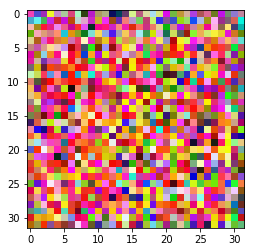

Epoch: 0, iteration: 0, Discriminator Loss:1.44706475735, Generator Loss: 0.726667642593


In [ ]:
with tf.Session() as session:
    
    #initialize all variables
    session.run(tf.global_variables_initializer())
    
    #for each epcohs
    for epoch in range(num_epcohs):
        
        #for number of batches
        for i in range(num_batches):
            
            #select start and end of the batch
            start = i * batch_size
            end = (i + 1) * batch_size
            
            #sample batch images
            batch_images = x_train[start:end]
            
            #train the discriminator after every two steps
            if(steps % 2 == 0):
                
                #train the discriminator
                _, discriminator_loss = session.run([d_optimizer,D_loss], feed_dict={x: batch_images, is_training:True, learning_rate:lr})
               
            
            #train the generator and discriminator
            _, generator_loss = session.run([g_optimizer,G_loss], feed_dict={x: batch_images, is_training:True, learning_rate:lr})
            _, discriminator_loss = session.run([d_optimizer,D_loss], feed_dict={x: batch_images, is_training:True, learning_rate:lr})
            display.clear_output(wait=True)  
            
            #generate new image
            generate_new_samples(session, 1, z_dim)
            print("Epoch: {}, iteration: {}, Discriminator Loss:{}, Generator Loss: {}".format(epoch,i,discriminator_loss,generator_loss))
            

            steps += 1

Train the DCGAN for several epochs, so that you can see better images.


Thus, we learned that DCGAN is similar to GANs except that it uses a convolutional network instead of a feedforward network in the generator and discriminator. In the next section, we will learn about LSGAN.